# Stock Price Prediction

Hello......, in this project I predict the price of infrastructure stocks in Indonesia using the Regression Ridge and LSTM (Long short-term memory) methods.

In [1]:
from __future__ import division
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow import keras

In [2]:
from pandas import Series,DataFrame

%matplotlib inline

import pandas_datareader as web

from datetime import datetime

In [3]:
con_list = ['WIKA.JK', 'WSKT.JK', 'ADHI.JK', 'PTPP.JK', '^JKSE']

end_time = datetime.now()
start_time = datetime(end_time.year-1,end_time.month,end_time.day)

stock_price = web.DataReader(con_list,'yahoo',start_time,end_time)['Adj Close']
stock_price.columns = ['WIKA', 'WSKT', 'ADHI', 'PTPP', 'JKSE']

stock_volume = web.DataReader(con_list,'yahoo',start_time,end_time)['Volume']
stock_volume.columns = ['WIKA', 'WSKT', 'ADHI', 'PTPP', 'JKSE']

In [4]:
stock_price

,WIKA,WSKT,ADHI,PTPP,JKSE
Date,,,,,
2020-02-10,1841.907227,1129.552490,955.383545,1350.347168,5952.083008
2020-02-11,1885.189697,1144.480469,955.383545,1383.985718,5954.396973
2020-02-12,1889.998779,1134.528442,940.834595,1359.958130,5913.081055
2020-02-13,1870.762207,1094.720459,897.187622,1297.486572,5871.954102
2020-02-14,1870.762207,1089.744385,897.187622,1307.097656,5866.944824
...,...,...,...,...,...
2021-02-03,1965.000000,1415.000000,1405.000000,1660.000000,6077.745117
2021-02-04,1895.000000,1405.000000,1370.000000,1655.000000,6107.215820
2021-02-05,1935.000000,1440.000000,1400.000000,1690.000000,6151.729004


In [5]:
stock_price.describe()

,WIKA,WSKT,ADHI,PTPP,JKSE
count,242.000000,242.000000,242.000000,242.000000,241.000000
mean,1367.669754,857.689322,796.950701,1068.871428,5248.584034
std,389.476482,355.829912,389.571066,415.174590,554.874829
min,697.327820,396.089752,374.393982,467.095184,3937.632080
25%,1115.000000,607.072266,565.000000,830.000000,4904.087891
50%,1232.500000,715.000000,611.057495,940.000000,5115.127930
75%,1755.342438,1067.380341,917.934143,1279.566132,5688.920898
max,2360.000000,1920.000000,1870.000000,2230.000000,6435.205078


normalisasi harga saham berdasarkan harga awal

In [6]:
def normalize(df):
  x = df.copy()
  for i in x.columns:
    x[i] = x[i]/x[i][0]
  return x

In [7]:
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns:
    fig.add_scatter(x = df.index, y = df[i], name = i)
  fig.show()

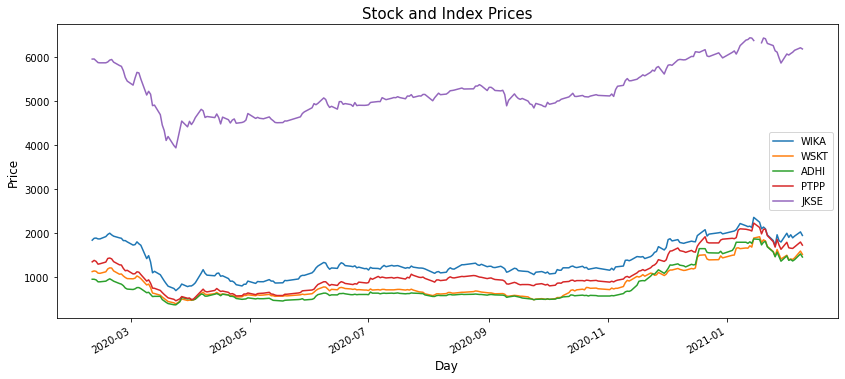

In [8]:
stock_price.plot(legend=True, figsize=(14,6))
plt.xlabel('Day', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Stock and Index Prices', fontsize=15)
plt.show()

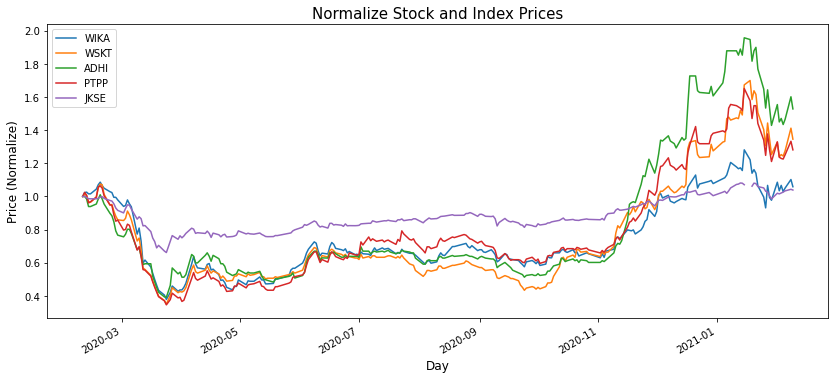

In [9]:
normalize(stock_price).plot(legend=True, figsize=(14,6))
plt.xlabel('Day', fontsize=12)
plt.ylabel('Price (Normalize)', fontsize=12)
plt.title('Normalize Stock and Index Prices', fontsize=15)
plt.show()

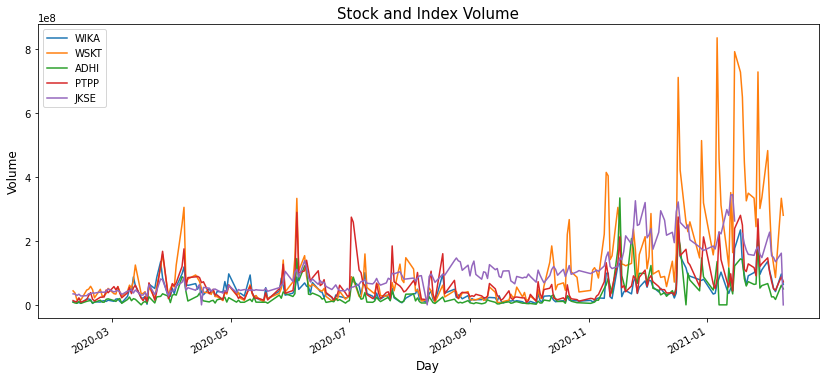

In [10]:
stock_volume.plot(legend=True, figsize=(14,6))
plt.xlabel('Day', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.title('Stock and Index Volume', fontsize=15)
plt.show()

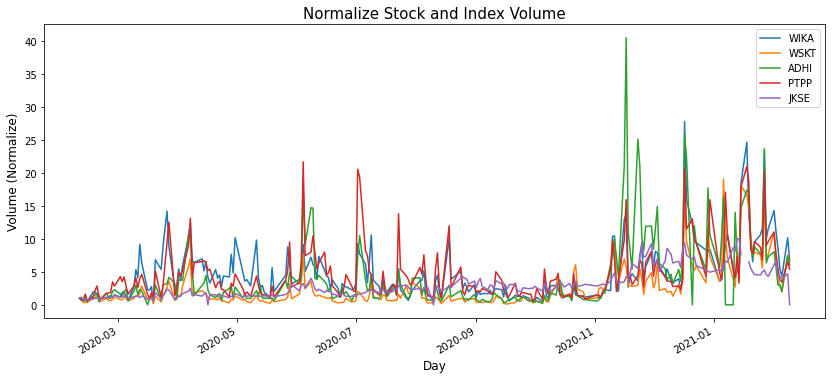

In [11]:
normalize(stock_volume).plot(legend=True, figsize=(14,6))
plt.xlabel('Day', fontsize=12)
plt.ylabel('Volume (Normalize)', fontsize=12)
plt.title('Normalize Stock and Index Volume', fontsize=15)
plt.show()

# Ridge Regression
Ridge regression is a popular parameter estimation method used to address the collinearity problem frequently arising in multiple linear regression. The formulation of the ridge methodology is reviewed and properties of the ridge estimates capsulated. In particular, four rationales leading to a regression estimator of the ridge form are summarized. Algebraic properties of the ridge regression coefficients are given, which elucidate the behavior of a ridge trace for small values of the ridge parameter (i.e., close to the least squares solution) and for large values of the ridge parameter. Further properties involving coefficient sign changes and rates-of-change, as functions of the ridge parameter, are given for specific correlation structures among the independent variables. These results help relate the visual behavior of a ridge trace to the underlying structure of the data (John Wiley & Sons, Inc. WIREs Comp Stat 2009 1 93–100).

In [12]:
def price_n_volume(price, vol, name_stock):
    return pd.DataFrame({'Price': price[name_stock], 'Volume': vol[name_stock]})

In [13]:
def next_day(data):  
  n = 1
  data['Target'] = data[['Price']].shift(-n)
  return data

In [14]:
price_volume = price_n_volume(stock_price, stock_volume, 'WIKA')
price_volume

,Price,Volume
Date,,
2020-02-10,1841.907227,9499800.0
2020-02-11,1885.189697,10837900.0
2020-02-12,1889.998779,6564600.0
2020-02-13,1870.762207,7374200.0
2020-02-14,1870.762207,4612100.0
...,...,...
2021-02-03,1965.000000,82126800.0
2021-02-04,1895.000000,51300700.0
2021-02-05,1935.000000,41503100.0


In [15]:
target = next_day(price_volume)
target = target[:-1]
target

,Price,Volume,Target
Date,,,
2020-02-10,1841.907227,9499800.0,1885.189697
2020-02-11,1885.189697,10837900.0,1889.998779
2020-02-12,1889.998779,6564600.0,1870.762207
2020-02-13,1870.762207,7374200.0,1870.762207
2020-02-14,1870.762207,4612100.0,1923.662842
...,...,...,...
2021-02-02,1905.000000,105361200.0,1965.000000
2021-02-03,1965.000000,82126800.0,1895.000000
2021-02-04,1895.000000,51300700.0,1935.000000


In [16]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
target_scaled = sc.fit_transform(target)

In [17]:
X = target_scaled[:, :2]
y = target_scaled[:, 2]

In [18]:
split = int(0.7 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

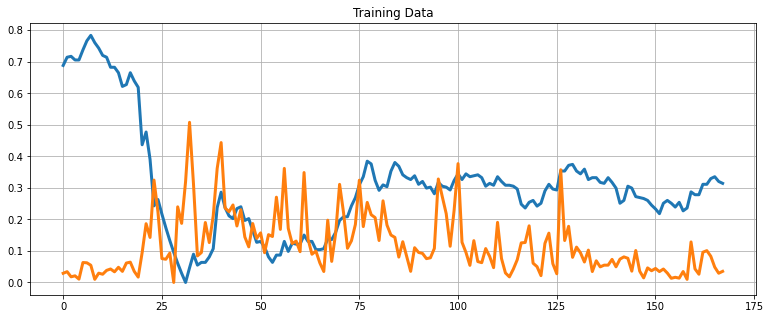

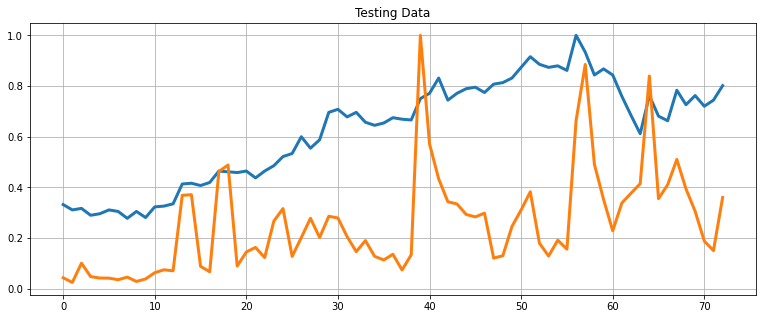

In [19]:
def show_plot(data, title):
  plt.figure(figsize = (13, 5))
  plt.plot(data, linewidth = 3)
  plt.title(title)
  plt.grid()

show_plot(X_train, 'Training Data')
show_plot(X_test, 'Testing Data')

In [20]:
from sklearn.linear_model import Ridge
regression_model = Ridge()
regression_model.fit(X_train, y_train)
Ridge()

Ridge()

In [21]:
accuracy = regression_model.score(X_test, y_test)
print("Linear Regression Score: ", accuracy)

Linear Regression Score:  0.7192790011264024


In [22]:
price_prediction = regression_model.predict(X)

In [23]:
target_price = []
for i in target_scaled:
  target_price.append(i[0])

In [24]:
ridge_prediction = DataFrame({'Price':target_price, 'Ridge Prediction': price_prediction})
ridge_prediction.index = target.index

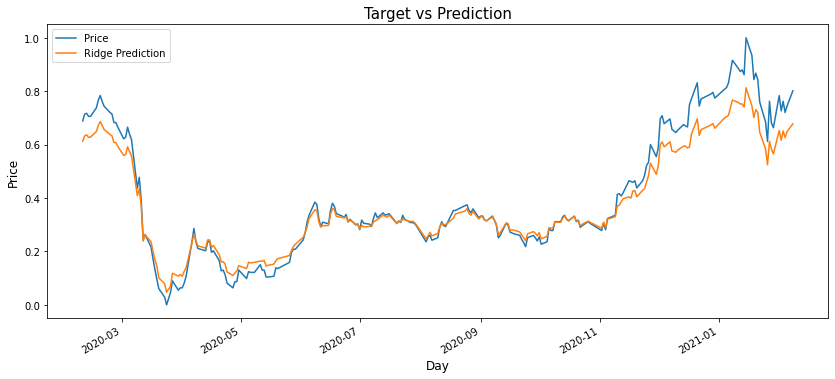

In [25]:
ridge_prediction.plot(legend=True, figsize=(14,6))
plt.xlabel('Day', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Target vs Prediction', fontsize=15)
plt.show()

# LSTM
Long short-term memory (LSTM) can solve many tasks not solvable by previous learning algorithms for recurrent neural networks (RNNs). We identify a weakness of LSTM networks processing continual input streams without explicitly marked sequence ends. Without resets, the internal state values may grow indefinitely and eventually cause the network to break down. Our remedy is an adaptive “forget gate” that enables an LSTM cell to learn to reset itself at appropriate times, thus releasing internal resources. We review an illustrative benchmark problem on which standard LSTM outperforms other RNN algorithms. All algorithms (including LSTM) fail to solve a continual version of that problem. LSTM with forget gates, however, easily solves it in an elegant way(F.A. Gers, J. Schmidhuber, F. Cummins, ICANN99, 1999, 850 – 855).

In [26]:
price_volume = price_n_volume(stock_price, stock_volume, 'WIKA')
price_volume 

,Price,Volume
Date,,
2020-02-10,1841.907227,9499800.0
2020-02-11,1885.189697,10837900.0
2020-02-12,1889.998779,6564600.0
2020-02-13,1870.762207,7374200.0
2020-02-14,1870.762207,4612100.0
...,...,...
2021-02-03,1965.000000,82126800.0
2021-02-04,1895.000000,51300700.0
2021-02-05,1935.000000,41503100.0


In [27]:
training_data = price_volume.iloc[:,:].values

In [28]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_scaled = sc.fit_transform(training_data)

In [29]:
X = []
y = []
for i in range(1, len(price_volume)):
    X.append(training_scaled [i-1:i, 0])
    y.append(training_scaled [i, 0])

In [30]:
X = np.asarray(X)
y = np.asarray(y)

In [31]:
split = int(0.7 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [32]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape

((168, 1, 1), (73, 1, 1))

In [33]:
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(280, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(280, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(280)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 280)            315840    
_________________________________________________________________
dropout (Dropout)            (None, 1, 280)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 280)            628320    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 280)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 280)               628320    
_________________________________________________________________
dense (Dense)                (None, 1)                 281   

In [34]:
history = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 32,
    validation_split = 0.2
)

Train on 134 samples, validate on 34 samples
Epoch 1/20
134/134 [==============================] - 7s 49ms/sample - loss: 0.1218 - val_loss: 0.0573
Epoch 2/20
134/134 [==============================] - 0s 1ms/sample - loss: 0.0896 - val_loss: 0.0235
Epoch 3/20
134/134 [==============================] - 0s 1ms/sample - loss: 0.0467 - val_loss: 0.0010
Epoch 4/20
134/134 [==============================] - 0s 1ms/sample - loss: 0.0220 - val_loss: 0.0206
Epoch 5/20
134/134 [==============================] - 0s 1ms/sample - loss: 0.0271 - val_loss: 0.0053
Epoch 6/20
134/134 [==============================] - 0s 1ms/sample - loss: 0.0167 - val_loss: 7.1416e-04
Epoch 7/20
134/134 [==============================] - 0s 1ms/sample - loss: 0.0176 - val_loss: 7.7547e-04
Epoch 8/20
134/134 [==============================] - 0s 978us/sample - loss: 0.0149 - val_loss: 0.0012
Epoch 9/20
134/134 [==============================] - 0s 985us/sample - loss: 0.0096 - val_loss: 0.0025
Epoch 10/20
134/134 [===

In [35]:
prediction = model.predict(np.reshape(X, (X.shape[0], X.shape[1], 1)))

In [36]:
test_prediction = []

for i in prediction:
  test_prediction.append(i[0])

In [37]:
lstm_prediction = DataFrame({'LSTM Prediction':test_prediction})
indeks = price_volume.index
indeks = indeks[1:]
lstm_prediction.index = indeks

In [38]:
price = []
for i in training_scaled:
  price.append(i[0])

In [39]:
lstm_prediction['Price'] = price[1:]

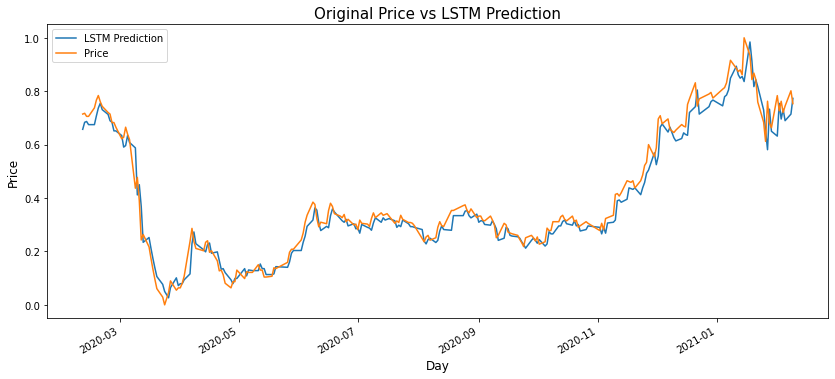

In [40]:
lstm_prediction.plot(legend=True, figsize=(14,6))
plt.xlabel('Day', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Original Price vs LSTM Prediction', fontsize=15)
plt.show()